<a href="https://colab.research.google.com/github/gon-uri/bird_detection/blob/main/basic_bird_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Install libraries and download datasets

First we install torchaudio, a library with different pytorch resources for audio data. Then we also install kaggle library to dowload the enviromental sound dataset. Notice you will have to locate your "kaggle.json" API token on your root folder (to create and download your kaggle API token follow this instructions https://www.kaggle.com/docs/api).

In [ ]:
!pip install torchaudio librosa boto3

! pip install -q kaggle
#! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mmoreaux/environmental-sound-classification-50

 99% 1.40G/1.42G [00:10<00:00, 122MB/s]
100% 1.42G/1.42G [00:10<00:00, 140MB/s]


We unzip the content of the dataset.

In [ ]:
!unzip environmental-sound-classification-50.zip

In [ ]:
!nvidia-smi -L
!nvidia-smi

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6e534014-6d7e-6e26-e7f8-ffc7c78fb209)
Mon Sep 13 17:04:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
           

# 2) Load datasets and display examples

In [ ]:
# Needed imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchaudio

from IPython.display import Audio
from scipy.io import wavfile
from tqdm import tqdm
import pickle
import glob

We create some handy functions to display information about sounds.

In [ ]:
# Function to print sound stats.
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

# Function to plot sound waveform.
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

# Function to plot sound spectrogram.
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


# Prepare the colab to play audios.

# Set to True if we are in colaboratory of False elsewere
colaboratory = True

if colaboratory:
    # Load the calc module
    !rm calc.*
    !wget https://raw.githubusercontent.com/R6500/Python-bits/master/Modules/calc.py

#Import the module
import calc

# Erase output after import
from IPython.display import clear_output
clear_output()

# Check loaded module
try:
    print('calc version: ',calc.version)
except:
    print('Error loading the calc module')

# Indicate the calc module if we are inside colaboratory
calc.setColaboratory(colaboratory)

calc version:  2/7/2018B


We inspect and listen to some sound of the dataset.

Sample Rate: 44100
Shape: (1, 220500)
Dtype: torch.float32
 - Max:      0.012
 - Min:     -0.013
 - Mean:    -0.000
 - Std Dev:  0.002

tensor([[0.0026, 0.0028, 0.0027,  ..., 0.0019, 0.0029, 0.0025]])



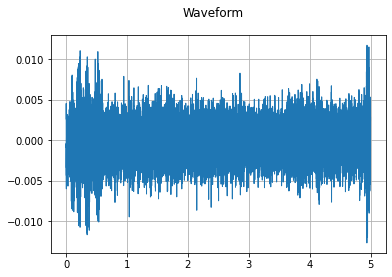

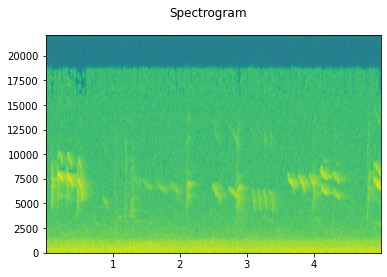

In [ ]:
#Folder where audios are located
folder_audios = '/content/audio/audio/'

# Load the sounds data
df = pd.read_csv('esc50.csv')

# Select the data of the sound categories we will use
df_background = df[df['category']=='chirping_birds']['filename']
df_wind = df[df['category']=='wind']['filename']


# Select the soudn category for the example
category = df_background #df_wind

# Select an idx for example
file_num = 10

# Load and display audio properties
filename = category.iloc[file_num]
waveform, sample_rate = torchaudio.load(folder_audios + filename)
waveform = torch.nn.functional.normalize(waveform)
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
Audio(waveform,rate=sample_rate)

Now we load the dataset of the kind of birds we would like to identify. In this case, we will focus on Chingolos ([Zonotrichia capensis ](https://es.wikipedia.org/wiki/Zonotrichia_capensis)).

In [ ]:
# Folder location of Target bird songs (train and test)
bird_train_folder = '/content/Chingolos/'
bird_test_folder = '/content/Chingolos_test/'

# Create lists containing birdsongs filenames
chingolos_filenames = glob.glob(bird_train_folder + "*.wav")
chingolos_filenames_test = glob.glob(bird_test_folder + "*.wav") 

We display the info of one of the songs as an example.

Sample Rate: 44100
Shape: (1, 71735)
Dtype: torch.float32
 - Max:      0.017
 - Min:     -0.018
 - Mean:    -0.000
 - Std Dev:  0.004

tensor([[ 7.8416e-05,  9.1486e-05,  6.5347e-05,  ..., -1.1762e-04,
         -7.8416e-05, -7.8416e-05]])



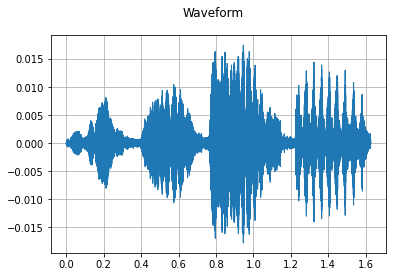

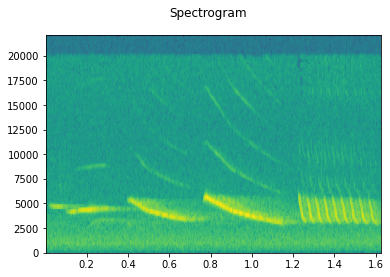

In [ ]:
# Display a random example
file_num = 0
waveform2, sample_rate2 = torchaudio.load(chingolos_filenames[file_num])
waveform2 = torch.nn.functional.normalize(waveform2)
print_stats(waveform2, sample_rate=sample_rate2)
plot_waveform(waveform2, sample_rate2)
plot_specgram(waveform2, sample_rate2)
Audio(waveform2,rate=sample_rate)

# 3) Define Parameters and functions to create the dataset

We set the parameters we will use to create the training and test datasets.

In [ ]:
# Sound sample length (in Seconds)
SOUND_LENGTH = 2.5 

# Proportion to bird max (like positining the wind at 4 mts distance)
WIND_LEVEL = 0.2 

# Proportion to bird max (like positining the background at 4 mts distance)
BACKGROUND_LEVEL = 0.2

# Sampling rate of input sounds (in Hz)
SAMPLING_RATE = 44100 

# Maximum distance of the target birds 
# (Ranges in meters from center of the Microphones array)
LOCATION_RANGES = [10,10,5]

# Sound speed in meter per seconds
SOUND_SPEED = 343 

# Batch size for data loaders
BATACH_SIZE = 100

# Location of the microphones - List of arrays [x,y,z]
MIC_LOCATIONS = [np.asarray([1,1,0]),np.asarray([1,-1,0]),np.asarray([-1,-1,0]),np.asarray([-1,1,0])]

# Number of Microphones in the array
MIC_NUM = len(MIC_LOCATION)


TOTAL_STEPS = int(SOUND_LENGTH*SAMPLING_RATE)
MAX_DISTANCE = np.max(np.linalg.norm(MIC_LOCATIONS - np.asarray(LOCATION_RANGES),axis=1))
MAX_DELAY_STEPS = int(SAMPLING_RATE * MAX_DISTANCE/SOUND_SPEED)

We create functions to get a random elements from the different datasets.

In [ ]:
# Get a random wind song
def get_wind(df_wind):
    id = np.random.randint(0,df_wind.shape[0]-1)
    filename = df_wind.iloc[id]
    waveform, sample_rate = torchaudio.load(folder_audios + filename)
    # We load the sound and convert it to the selected sampling rate
    waveform = torchaudio.functional.resample(waveform = waveform, orig_freq = float(sample_rate), new_freq = float(SAMPLING_RATE))
    wind_waveform = torch.nn.functional.normalize(waveform)
    return wind_waveform

# Get random background sound
def get_background(df_background):
    id = np.random.randint(0,df_background.shape[0]-1)
    filename = df_background.iloc[id]
    waveform, sample_rate = torchaudio.load(folder_audios + filename)
    # We load the sound and convert it to the selected sampling rate
    waveform = torchaudio.functional.resample(waveform = waveform, orig_freq = float(sample_rate), new_freq = float(SAMPLING_RATE))
    background_waveform = torch.nn.functional.normalize(waveform)
    return background_waveform

# Get a random bird song
def get_bird_waveform(chingolos_filenames):
    id = np.random.randint(0,len(chingolos_filenames)-1)
    filename = chingolos_filenames[id]
    waveform, sample_rate = torchaudio.load(filename)
    # We load the sound and convert it to the selected sampling rate
    waveform = torchaudio.functional.resample(waveform = waveform, orig_freq = float(sample_rate), new_freq = float(SAMPLING_RATE))
    # print('Bird sample rate: ', sample_rate)
    bird_waveform = torch.nn.functional.normalize(waveform)
    return bird_waveform

# Get a random location for the bird
def get_bird_location(ranges):
    x = np.random.uniform(-ranges[0],ranges[0])
    y = np.random.uniform(-ranges[1],ranges[1])
    z = np.random.uniform(0,ranges[2])
    return np.asarray([x,y,z])

# Get a random location for the background
def get_background_location(ranges):
    x_abs = np.random.uniform(ranges[0]/4,ranges[0])
    x = x_abs * np.random.choice([-1,1],p=[0.5, 0.5])
    y_abs = np.random.uniform(ranges[1]/4,ranges[1])
    y = y_abs * np.random.choice([-1,1],p=[0.5, 0.5])
    z_abs = np.random.uniform(ranges[2]/4,ranges[2])
    z = z_abs * np.random.choice([-1,1],p=[0.5, 0.5])
    return np.asarray([x,y,z])

In [ ]:
np.random.choice([-1,1],p=[0.5, 0.5])

-1

In [ ]:
def add_source(source_waveform, source_location, target_waveform):

    # Compute source properties on MICs
    distances = []
    delays = []
    factors = []
    for position in MIC_LOCATIONS:
        # Compute source distance to Mics
        dist = np.linalg.norm(position-source_location)
        distances.append(dist)
        # Compute delay in sampling units
        delay = int(SAMPLING_RATE * np.divide(dist,SOUND_SPEED))
        delays.append(delay)
        # Compute amplitude modulation due to distance 
        factor = np.divide(1.0,1.0+dist)
        factors.append(factor)

    # Compute offset to place the source at random place in sound sample
    source_steps = source_waveform.shape[1]
    extra_steps = TOTAL_STEPS - source_steps - int(np.max(delays))
    steps_offset = np.random.randint(0,extra_steps-1)

    # Add source to the target waveform
    for i in range(MIC_NUM):
        # Offset for the MIC
        offset = steps_offset + delays[i]
        # Add source to MIC
        target_waveform[i,offset:offset+source_steps] = target_waveform[i,offset:offset+source_steps] + factors[i]*source_waveform[0,:]
    
    return target_waveform

The following function is the one in wich we compose one instance. The output sound is a sinthetic simulation of what would the array of microphones record in the field.  If present, we stage the sound source (a singing Chingolo) in the receptive field and compute the corresponding times delays between the emtion of the sound and the arrival to the different microphones. We also add a common background sound of real field recordings (with other birds singing) and wind noise (different for each of the microphones).

In [ ]:
def generate_instance(bird_waveform, background_waveform, wind_waveform, mic_location, bird_location, bird_present = True):

    # Generates empty tensor to fill
    final_waveform = torch.zeros([MIC_NUM,TOTAL_STEPS])

    if bird_present:
        # Compute bird distance to Mics 
        dist_0 = np.linalg.norm(mic_location[0]-bird_location)
        dist_1 = np.linalg.norm(mic_location[1]-bird_location)
        dist_2 = np.linalg.norm(mic_location[2]-bird_location)
        dist_3 = np.linalg.norm(mic_location[3]-bird_location)

        # Compute delay in sampling units
        delay_0 = int(SAMPLING_RATE * np.divide(dist_0,SOUND_SPEED))
        delay_1 = int(SAMPLING_RATE * np.divide(dist_1,SOUND_SPEED))
        delay_2 = int(SAMPLING_RATE * np.divide(dist_2,SOUND_SPEED))
        delay_3 = int(SAMPLING_RATE * np.divide(dist_3,SOUND_SPEED))

        # Compute amplitude modulation due to distance 
        factor_0 = np.divide(1.0,1.0+dist_0)
        factor_1 = np.divide(1.0,1.0+dist_1)
        factor_2 = np.divide(1.0,1.0+dist_2)
        factor_3 = np.divide(1.0,1.0+dist_3)

        # Compute offset to place the bird song at random place in sound sample
        bird_steps = bird_waveform.shape[1]
        extra_steps = total_steps - bird_steps - int(np.max((delay_0,delay_1,delay_2,delay_3)))
        steps_offset = np.random.randint(0,extra_steps-1)

        # Offset for the different birds
        offset_0 = steps_offset + delay_0
        offset_1 = steps_offset + delay_1
        offset_2 = steps_offset + delay_2
        offset_3 = steps_offset + delay_3

        # Add bird to First MIC
        final_waveform[0,offset_0:offset_0+bird_steps] = factor_0*bird_waveform[0,:]
        # Add bird to Second MIC
        final_waveform[1,offset_1:offset_1+bird_steps] = factor_1*bird_waveform[0,:]
        # Add bird to Third MIC
        final_waveform[2,offset_2:offset_2+bird_steps] = factor_2*bird_waveform[0,:]
        # Add bird to Fourth MIC
        final_waveform[3,offset_3:offset_3+bird_steps] = factor_3*bird_waveform[0,:]

    # Extract different parts of the wind sound to add to Mics
    extra_steps_wind = wind_waveform.shape[1] - total_steps - 1
    init_wind_0 = 0
    init_wind_1 = int(extra_steps_wind/3)
    init_wind_2 = int(2*extra_steps_wind/3)
    init_wind_3 = int(extra_steps_wind)
    wind_0 = WIND_LEVEL * wind_waveform[:,init_wind_0:init_wind_0+total_steps]
    wind_1 = WIND_LEVEL * wind_waveform[:,init_wind_1:init_wind_1+total_steps]
    wind_2 = WIND_LEVEL * wind_waveform[:,init_wind_2:init_wind_2+total_steps]
    wind_3 = WIND_LEVEL * wind_waveform[:,init_wind_3:init_wind_3+total_steps]

    # Extract Background bird sounds
    extra_steps_background = background_waveform.shape[1] - total_steps - 1
    background_offset = np.random.randint(0,extra_steps_background-1)
    background = BACKGROUND_LEVEL * background_waveform[:,background_offset:background_offset+total_steps]

    # Add noise and background to First MIC
    final_waveform[0,:] = final_waveform[0,:] + background + wind_0

    # Add noise and background to Second MIC
    final_waveform[1,:] = final_waveform[1,:] + background + wind_1

    # Add noise and background to Third MIC
    final_waveform[2,:] = final_waveform[2,:] + background + wind_2

    # Add noise and background to Fourth MIC
    final_waveform[3,:] = final_waveform[3,:] + background + wind_3

    return final_waveform

In [ ]:
def generate_instance(bird_waveform, background_waveform, wind_waveform, bird_location, background_location, bird_present = True):

    # Generates empty tensor to fill
    final_waveform = torch.zeros([MIC_NUM,TOTAL_STEPS])

    # Add bird sound (if present)
    if bird_present:
        final_waveform = add_source(bird_waveform, bird_location, final_waveform)

    # Add background sound
    extra_steps_background = background_waveform.shape[1]- TOTAL_STEPS - 1
    background_offset = np.random.randint(0,extra_steps_background-1)
    background_length = TOTAL_STEPS - MAX_DELAY_STEPS - 1
    background = background_waveform[:,background_offset:background_offset+background_length] # * BACKGROUND_LEVEL
    final_waveform = add_source(background, background_location, final_waveform)

    # Extract different parts of the wind sound to add to Mics
    extra_steps_wind = wind_waveform.shape[1] - TOTAL_STEPS - 1
    extra_fraction = int(extra_steps_wind/(MIC_NUM-1))
    for i in range(MIC_NUM):
        init_wind = int(i*extra_fraction)
        final_waveform[i,:]  = final_waveform[i,:] + WIND_LEVEL * wind_waveform[:,init_wind:init_wind+TOTAL_STEPS]

    # # Extract Background bird sounds
    # extra_steps_background = background_waveform.shape[1] - total_steps - 1
    # background_offset = np.random.randint(0,extra_steps_background-1)
    # background = BACKGROUND_LEVEL * background_waveform[:,background_offset:background_offset+total_steps]

    # # Add background to MICs
    # for i in range(MIC_NUM):
    #     final_waveform[i,:]  = final_waveform[i,:] + background

    return final_waveform

In [ ]:
# def generate_tensor_dataset(num_instances, chingolos_filenames, df_background, df_wind, percent_bird = 0.7):

#     total_steps = int(SOUND_LENGTH*SAMPLING_RATE)  
#     tensor_dataset = torch.zeros([num_instances,4,total_steps])
#     targets = torch.zeros([num_instances, 4])

#     for i in tqdm(range(num_instances)):
#         wind_waveform = get_wind(df_wind)
#         background_waveform = get_background(df_background)
#         bird_waveform = get_bird_waveform(chingolos_filenames)
#         bird_present = np.random.choice([0,1],p=[(1-percent_bird), percent_bird])

#         if bird_present:
#             bird_location = get_bird_location(LOCATION_RANGES)
#         else:
#             bird_location = np.asarray([0,0,0])
#         final_waveform = generate_instance(bird_waveform, background_waveform, wind_waveform, mics_location, bird_location, bird_present = bird_present)

#         tensor_dataset[i,:,:] = final_waveform

#         numpy_target = np.concatenate((np.asarray([bird_present]),bird_location))
#         # numpy_target = np.asarray(bird_location))

#         targets[i,:] = torch.tensor(numpy_target)

#     return tensor_dataset, targets


In [ ]:
def generate_folder_dataset(num_instances, folder_name, chingolos_filenames, df_background, df_wind, percent_bird = 0.7):

    total_steps = int(SOUND_LENGTH*SAMPLING_RATE)  
    # tensor_dataset = torch.zeros([num_instances,4,total_steps])
    target_matrix = np.zeros([num_instances, 4])
    filenames_list = []

    for i in tqdm(range(num_instances)):
        wind_waveform = get_wind(df_wind)
        background_waveform = get_background(df_background)
        bird_waveform = get_bird_waveform(chingolos_filenames)
        bird_present = np.random.choice([0,1],p=[(1-percent_bird), percent_bird])
        background_location = get_background_location(LOCATION_RANGES)

        if bird_present:
            bird_location = get_bird_location(LOCATION_RANGES)
        else:
            bird_location = np.asarray([0,0,0])

        final_waveform = generate_instance(bird_waveform, background_waveform, wind_waveform, bird_location, background_location, bird_present = bird_present)

        filename_audio = folder_name + str(i) + '.wav'
        filenames_list.append(filename_audio)
        torchaudio.save(filename_audio, final_waveform, SAMPLING_RATE)
        numpy_target = np.concatenate((np.asarray([bird_present]),bird_location))
        target_matrix[i,:] = numpy_target

    return filenames_list, target_matrix

# 4) Create and save the Dataset

In [ ]:
training_folder = '/content/train/'
filenames_list, target_matrix = generate_folder_dataset(10000, training_folder, chingolos_filenames, df_background, df_wind, percent_bird = 0.5)

100%|██████████| 10000/10000 [03:57<00:00, 42.19it/s]


In [ ]:
test_folder = '/content/test/'
filenames_list_test, target_matrix_test = generate_folder_dataset(3000, test_folder, chingolos_filenames_test, df_background, df_wind, percent_bird = 0.5)


100%|██████████| 3000/3000 [01:05<00:00, 46.09it/s]


In [ ]:
with open('filenames_list.pickle', 'wb') as handle:
    pickle.dump(filenames_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('target_matrix.pickle', 'wb') as handle:
    pickle.dump(target_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filenames_list_test.pickle', 'wb') as handle:
    pickle.dump(filenames_list_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('target_matrix_test.pickle', 'wb') as handle:
    pickle.dump(target_matrix_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 5) Extra: Load the dataset if it is already created

If you already created the dataset in a previous run, you can only load the filenames lists and the target matrices. 

In [ ]:
with open('filenames_list.pickle', 'rb') as handle:
    filenames_list = pickle.load(handle)

with open('target_matrix.pickle', 'rb') as handle:
    target_matrix = pickle.load(handle)

with open('filenames_list_test.pickle', 'rb') as handle:
    filenames_list_test = pickle.load(handle)

with open('target_matrix_test.pickle', 'rb') as handle:
    target_matrix_test = pickle.load(handle)

# 6) Define the Dataloader

Import Pytorch libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Create Dataset object

In [ ]:
class ChingolosDataset(Dataset):
# Wrapper for the Chingolos dataset
    #  Argument List
    #  filenames_list with the list of WAVs file names in the folder
    #  target_matrix matrix with target values [bird_present, x_position, y_position, z_position]
    
    def __init__(self, filenames_list, target_matrix):
        self.filenames_list = filenames_list
        self.target_matrix = torch.tensor(target_matrix)
        # self.mixer = torchaudio.transforms.DownmixMono() #UrbanSound8K uses two channels, this will convert them to one

    def __getitem__(self, index):
        #format the file path and load the file
        path = self.filenames_list[index]
        sound = torchaudio.load(path, normalize  = True)
        # sound = sound.permute(1, 0) # NO SE ESTO PARA QUE ESTABA
        return sound[0].float(), self.target_matrix[index,:].float()
        # return sound[0].float(), self.target_matrix[index,0].float() # SOLO CLASIFiCACION
    
    def __len__(self):
        return len(self.filenames_list)


Instantiate the datasets and Dataloaders

In [ ]:
# Create Datasets
train_set = ChingolosDataset(filenames_list, target_matrix)
test_set = ChingolosDataset(filenames_list_test, target_matrix_test)

print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

# Create Dataloaders
#kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} # Needed for using datasets on gpu
train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATACH_SIZE, shuffle = True)#, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATACH_SIZE, shuffle = True)#, **kwargs)

Train set size: 10000
Test set size: 3000


Inspect a random instance of the dataset.


Target:  tensor([0., 0., 0., 0.])
Bird Present:  tensor(0.)
Bird Location:  tensor([0., 0.])


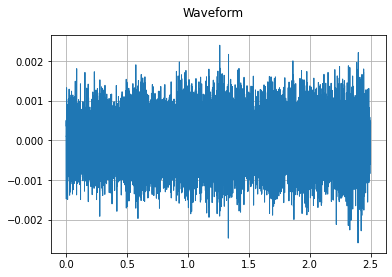

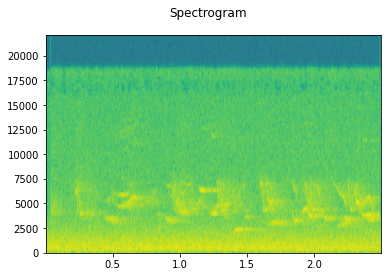

In [ ]:
for data, target in train_loader:
    full_batch_waveform = data
    full_batch_targets = target
    break

idx = np.random.randint(BATACH_SIZE)
waveform = full_batch_waveform[idx]
waveform_ch1 = waveform[0:1]

print('Target: ',full_batch_targets[idx] )
print('Bird Present: ',full_batch_targets[idx][0])
print('Bird Location: ',full_batch_targets[idx][1:3])
plot_waveform(waveform_ch1, sample_rate2)
plot_specgram(waveform_ch1, sample_rate2)
Audio(waveform_ch1,rate=sample_rate)

# 7) Define the model

We define a model that first uses 5 layers of 1D convolutions to generate 512 features of the waveform and then uses those features as an input for 2 fully connected layers. The first value of the output will be used to classify yes/no presence of a Chingolo, the following values will be used to predict the position of a bird, if present (if not, the target output is 0).

In [ ]:
kernel_size = int((3.0/SOUND_SPEED)*SAMPLING_RATE)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv1d(4, 128, kernel_size, 1)
        self.conv1 = nn.Conv1d(128, 128, 32, 16)
        self.bn1 = nn.BatchNorm1d(128, track_running_stats=True)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128, track_running_stats=True)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3, 3)
        self.bn3 = nn.BatchNorm1d(256, track_running_stats=True)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512, track_running_stats=True)
        # self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(33) # input should be 512x30 so this outputs a 512x1
        self.fc1 = nn.Linear(512, 64)
        # self.fc2 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(64, 4)
        # self.fc2 = nn.Linear(64, 1) # Solo CLASIFICACION
        
    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        # x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        # x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        # x = F.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        # x = F.relu(x)
        # x = self.pool4(x)
        x = self.avgPool(x)
        x = x.squeeze()
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # x = torch.sigmoid(x)
        return x

model = Net()
model.to(device)
print(model)

Net(
  (conv0): Conv1d(4, 128, kernel_size=(385,), stride=(1,))
  (conv1): Conv1d(128, 128, kernel_size=(32,), stride=(16,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(3,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgPool): AvgPool1d(kernel_size=(33,), stride=(33,), padding=(0,))
  (fc1): L

In [ ]:
# # del tensor_prueba
# torch.cuda.empty_cache()
# tensor_prueba,_ = generate_tensor_dataset(2, chingolos_filenames, df_background, df_wind, percent_bird = 0.7)
# out = model(tensor_prueba.to(device))
# out.shape

With torchsummmary we can have a 

In [ ]:
from torchsummary import summary
wav_lenght = int(SOUND_LENGTH*SAMPLING_RATE)
summary(model, (4,wav_lenght), batch_size=BATACH_SIZE, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1         [100, 128, 109866]         197,248
            Conv1d-2           [100, 128, 6865]         524,416
       BatchNorm1d-3           [100, 128, 6865]             256
         MaxPool1d-4           [100, 128, 1716]               0
            Conv1d-5           [100, 128, 1714]          49,280
       BatchNorm1d-6           [100, 128, 1714]             256
         MaxPool1d-7            [100, 128, 428]               0
            Conv1d-8            [100, 256, 142]          98,560
       BatchNorm1d-9            [100, 256, 142]             512
        MaxPool1d-10             [100, 256, 35]               0
           Conv1d-11             [100, 512, 33]         393,728
      BatchNorm1d-12             [100, 512, 33]           1,024
        AvgPool1d-13              [100, 512, 1]               0
           Linear-14                  [

In [ ]:
!nvidia-smi -L
!nvidia-smi

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6e534014-6d7e-6e26-e7f8-ffc7c78fb209)
Mon Sep 13 19:24:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |   1389MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
           

# 8) Define training and test functions

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.1, weight_decay = 0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)
loss_fn_cat = nn.BCEWithLogitsLoss()
# loss_fn_cat = nn.BCELoss()
loss_fn_pos = nn.MSELoss()

In [ ]:
def train(model, epoch, loss_list, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)

        # loss_category = loss_fn_cat(output[0][:,0:1], target[:,0:1]) #the loss functions expects a batchSizex10 input
        # loss_position = loss_fn_pos(output[0][:,1:3], target[:,1:3])
        # loss = loss_category + loss_position
        # loss.backward()

        loss_position = loss_fn_pos(output[:,1:3], target[:,1:3])
        loss_category = loss_fn_cat(output[:,0], target[:,0]) # Solo CLASIFICACION
        loss = loss_category + loss_position
        loss.backward()
        
        optimizer.step()

        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.detach().cpu()))
            
        loss_list.append(loss.detach().cpu())
            
        del data
        del target
        del output
        torch.cuda.empty_cache()

In [ ]:
def test(model, epoch):
    model.train()
    correct_train = 0
    i = 0
    accum_loss_position_x = 0
    accum_loss_position_y = 0
    accum_loss_position_z = 0
    accum_accuracy = 0
    accum_loss_category = 0
    
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        threshold = torch.tensor([0.0])

        loss_position_x = (output[:,1:2] - target[:,1:2]).abs().mean()
        loss_position_y = (output[:,2:3] - target[:,2:3]).abs().mean()
        loss_position_z = (output[:,3:4] - target[:,3:4]).abs().mean()
        loss_category = loss_fn_cat(output[:,0], target[:,0]) # Solo CLASIFICACION
        pred = (output[:,0].detach().cpu()>threshold).float()*1


        # loss = loss_fn_cat(output,target)
        # pred = (output[0][:,0]>threshold).float()*1
        

        # pred = output[0][:,0] > 510
        # pred = cat_output.max(2)[1] # get the index of the max log-probability
        
        # correct_train += pred.eq(target.float()).cpu().sum().item()
        
        # print(target.cpu())

        # print(output.detach().cpu())

        accum_accuracy +=  pred.eq(target[:,0].detach().cpu()).cpu().sum()
        accum_loss_category +=  loss_category.detach().cpu()
        accum_loss_position_x += loss_position_x.detach().cpu()
        accum_loss_position_y += loss_position_y.detach().cpu()
        accum_loss_position_z += loss_position_z.detach().cpu()
        i += 1

        # print(target.shape)
        # print(pred.eq(target.int()).cpu())

        del data
        del target
        del output
        del pred
        torch.cuda.empty_cache()

        # break

    print('Category Loss:',accum_loss_category/i)
    print('Positional Loss X:',accum_loss_position_x/i)
    print('Positional Loss Y:',accum_loss_position_y/i)
    print('Positional Loss Z:',accum_loss_position_z/i)
    print('Accuraccy:',accum_accuracy/i)

In [ ]:
def test_positives(model, epoch):
    model.train()
    correct_train = 0
    suma = 0
    suma_positives = 0
    accum_loss_position_x = 0
    accum_loss_position_y = 0
    accum_loss_position_z = 0
    accum_accuracy = 0
    accum_loss_category = 0
    
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        threshold = torch.tensor([0.0])

        pred = (output[:,0].detach().cpu()>threshold).float()*1
        loss_category = loss_fn_cat(output[:,0], target[:,0]) # Solo CLASIFICACION

        accum_accuracy +=  pred.eq(target[:,0].detach().cpu()).cpu().sum()
        accum_loss_category +=  loss_category.detach().cpu()
        
        suma += 1

        for j in range(len(target[:,0])):
            if target[j,0] == 1.0:
                loss_position_x = (output[j,1:2] - target[j,1:2]).abs().mean()
                loss_position_y = (output[j,2:3] - target[j,2:3]).abs().mean()
                loss_position_z = (output[j,3:4] - target[j,3:4]).abs().mean()
                
                
                accum_loss_position_x += loss_position_x.detach().cpu()
                accum_loss_position_y += loss_position_y.detach().cpu()
                accum_loss_position_z += loss_position_z.detach().cpu()
                suma_positives += 1

        del pred
        del data
        del target
        del output
        torch.cuda.empty_cache()


    print('Category Loss:',accum_loss_category/suma)
    print('Positional Loss X:',accum_loss_position_x/suma_positives)
    print('Positional Loss Y:',accum_loss_position_y/suma_positives)
    print('Positional Loss Z:',accum_loss_position_z/suma_positives)
    print('Accuraccy:',accum_accuracy/suma)

# 9) Training Loop

In [ ]:
loss_list = []
val_loss_list = []
log_interval = 20

In [ ]:
for epoch in range(1,2):
    if epoch == 31:
        print("First round of training complete. Setting learn rate to 0.001.")

    train(model, epoch, loss_list, log_interval)
    # test(model, epoch)

    scheduler.step()

Train Epoch: 1 [0/10000 (0%)]	Loss: 15.469786
Train Epoch: 1 [2000/10000 (20%)]	Loss: 14.601130
Train Epoch: 1 [4000/10000 (40%)]	Loss: 18.333204
Train Epoch: 1 [6000/10000 (60%)]	Loss: 15.617200
Train Epoch: 1 [8000/10000 (80%)]	Loss: 17.381542


In [ ]:
test(model, 1)

Category Loss: tensor(0.6931)
Positional Loss X: tensor(2.4809)
Positional Loss Y: tensor(2.5031)
Positional Loss Z: tensor(1.2405)
Positional Loss Z: tensor(50.7333)


In [ ]:
test_positives(model, 1)

Category Loss: tensor(0.6931)
Positional Loss X: tensor(4.9738)
Positional Loss Y: tensor(5.0100)
Positional Loss Z: tensor(2.5180)
Accuraccy: tensor(50.7333)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

In [ ]:
torch.save(model.state_dict(), root_dir + '/Chingolos/model_weights.pth')

In [ ]:

del model

torch.cuda.empty_cache()
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 4            |        cudaMalloc retries: 5         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   13737 MB |   13879 MB |   23608 MB |    9870 MB |\n|       from large pool |   13736 MB |   13874 MB |   23588 MB |    9851 MB |\n|       from small pool |       1 MB |       7 MB |      19 MB |      18 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   13737 MB |   13879 MB |   23608 MB |    9870 MB |\n|       from large pool |   13736 MB |   13874 MB |

In [ ]:
mem/1.25e+8

0.022129664

In [ ]:
test(model, epoch)

RuntimeError: ignored

In [ ]:
output.shape

torch.Size([20, 33, 24])

In [ ]:
tensor_prueba,_ = generate_tensor_dataset(128, chingolos_filenames, df_background, df_wind, percent_bird = 0.7)

100%|██████████| 128/128 [00:01<00:00, 112.52it/s]


In [ ]:
tensor_prueba.shape

torch.Size([128, 4, 110250])

In [ ]:
m = nn.Conv1d(4, 5, 1, stride=1)

output = m(tensor_prueba)

output.shape

torch.Size([128, 4, 110250])

In [ ]:
(3/SOUND_SPEED)

0.008746355685131196

In [ ]:
kernel_size = int((3/SOUND_SPEED)*SAMPLING_RATE)
kernel_size

385

In [ ]:
tensor_prueba = torch.zeros([100, 4, 110250])

In [ ]:
conv0 = nn.Conv1d(4, 128, kernel_size, 1)
conv1 = nn.Conv1d(128, 128, 32, 16)
bn1 = nn.BatchNorm1d(128)
pool1 = nn.MaxPool1d(4)
conv2 = nn.Conv1d(128, 128, 3)
bn2 = nn.BatchNorm1d(128)
pool2 = nn.MaxPool1d(4)
conv3 = nn.Conv1d(128, 256, 3, 3)
bn3 = nn.BatchNorm1d(256)
pool3 = nn.MaxPool1d(4)
conv4 = nn.Conv1d(256, 512, 3)
bn4 = nn.BatchNorm1d(512)
# pool4 = nn.MaxPool1d(4)
avgPool = nn.AvgPool1d(35)
fc1 = nn.Linear(512, 64)
fc1 = nn.Linear(64, 32)
fc2 = nn.Linear(32, 4)

In [ ]:
x = conv0(tensor_prueba)
x = conv1(x)
x = F.relu(bn1(x))
x = pool1(x)
x = conv2(x)
x = F.relu(bn2(x))
x = pool2(x)
x = conv3(x)
x = F.relu(bn3(x))
x = pool3(x)
x = conv4(x)
x = F.relu(bn4(x))
# x = pool4(x)
# x = avgPool(x)
# x = x.squeeze()
# x = fc1(x)
# x = F.relu(x)
# x = fc2(x)

In [ ]:
x.shape

torch.Size([100, 512, 33])

In [ ]:
1/0.005

200.0

In [ ]:
1/(220/SAMPLING_RATE)

200.45454545454547

In [ ]:
from torchsummary import summary
summary(model, tensor_prueba[0].shape, batch_size=128, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [128, 4, 110250]              20
            Conv1d-2          [128, 128, 27508]         112,768
       BatchNorm1d-3          [128, 128, 27508]             256
         MaxPool1d-4           [128, 128, 6877]               0
            Conv1d-5           [128, 128, 6875]          49,280
       BatchNorm1d-6           [128, 128, 6875]             256
         MaxPool1d-7           [128, 128, 1718]               0
            Conv1d-8            [128, 256, 858]          98,560
       BatchNorm1d-9            [128, 256, 858]             512
        MaxPool1d-10            [128, 256, 214]               0
           Conv1d-11            [128, 512, 106]         393,728
      BatchNorm1d-12            [128, 512, 106]           1,024
        MaxPool1d-13             [128, 512, 26]               0
        AvgPool1d-14              [128,

In [ ]:
tensor_prueba[0].shape

torch.Size([4, 110250])

GPU 0: Tesla T4 (UUID: GPU-aaf53b3a-31f0-89e2-7bd3-e4cd15d5df3a)


GPU 0: Tesla T4 (UUID: GPU-aaf53b3a-31f0-89e2-7bd3-e4cd15d5df3a)
Sun Aug 29 15:49:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |  14506MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                       

In [ ]:
kernel_size = int(0.005*SAMPLING_RATE)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv1d(4, 4, 1, 1)
        self.conv1 = nn.Conv1d(4, 128, kernel_size, 4)
        self.bn1 = nn.BatchNorm1d(128, track_running_stats=True)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128, track_running_stats=True)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3, 2)
        self.bn3 = nn.BatchNorm1d(256, track_running_stats=True)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3, 2)
        self.bn4 = nn.BatchNorm1d(512, track_running_stats=True)
        self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(26) # input should be 512x30 so this outputs a 512x1
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 4)
        # self.fc2 = nn.Linear(64, 1) # Solo CLASIFICACION
        
    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        # x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        # x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        # x = F.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        # x = F.relu(x)
        x = self.pool4(x)
        x = self.avgPool(x)
        x = x.squeeze()
        # x = x.permute(0, 2, 1) #change the 512x1 to 1x512
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # x = torch.sigmoid(x)
        return x

    # def predict(self, x):
    #     x = self.conv0(x)
    #     x = self.conv1(x)
    #     x = F.relu(self.bn1(x))
    #     x = self.pool1(x)
    #     x = self.conv2(x)
    #     x = F.relu(self.bn2(x))
    #     x = self.pool2(x)
    #     x = self.conv3(x)
    #     x = F.relu(self.bn3(x))
    #     x = self.pool3(x)
    #     x = self.conv4(x)
    #     x = F.relu(self.bn4(x))
    #     x = self.pool4(x)
    #     x = self.avgPool(x)
    #     x = self.squeeze()
    #     # x = x.permute(0, 2, 1) #change the 512x1 to 1x512
    #     x = self.fc1(x)
    #     x = F.relu(x)
    #     x = self.fc2(x)
    #     x = F.sigmoid(x)
        return x

model = Net()
model.to(device)
print(model)